In [1]:
%matplotlib inline

# TPB04 : Régression : modélisation du diffusiomètre NSCAT

In [2]:
from warnings import warn

import matplotlib.pyplot as plt
from pyparsing.helpers import DebugStartAction
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.neural_network import MLPRegressor

/Users/dahmani/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Introduction 
A l’aide des Perceptrons Multicouches (PMC), on veut simuler la fonction directe d’un diffusiomètre satellitaire mais aussi estimer la variance.  

Le diffusiomètre est un radar actif d’observation de la surface océanique (actif car il possède son propre source d’illumination de la surface d’observation, par rapport à d’autres radars dits passifs qui utilisent le rayonnement solaire). Son principe de mesure est basé sur la réflexion diffuse des ondes électromagnétiques qu’il a émises et qui sont diffusées dans toutes les directions par la surface océanique.  
Le coefficient de rétrodiffusion qu’il mesure est le rapport entre la puissance diffusée dans la direction du radar donc rétrodiffusée et la puissance incidente émise. Ce coefficient de rétrodiffusion (noté ***sigma0*** ou ***s0***) dépend de la rugosité de la surface de l’océan, de la géométrie de mesure (angle de visée ou d’incidence ***q***) et des caractéristiques du radar (la fréquence du signal utilisé, la polarisation des ondes électromagnétiques). 
La rugosité de surface dépend au premier ordre d’approximation du vent local soufflant sur la surface. Le vent engendre,
par l’intermédiaire d’une force de frottement, des vaguelettes de quelques centimètres de ***LO***   (longueur d’onde ou la distance entre 2 crêtes) qui elles interagissent avec les ondes émises par le radar, ondes aussi de quelques centimètres de ***LO***, selon les caractéristiques radars utilisées

Le diffusiomètre effectue des mesures à incidence oblique (***q*** entre 20$^oC$ et 50$^oC$), plus le vent est fort, plus la diffusion est importante et donc plus la mesure radar est forte. En résumé : à vent fort, diffusion plus importante dans toutes les directions et signal mesuré fort, tandis qu’à vent faible, faible diffusion dans la direction du radar et donc signal mesuré plus faible. 
Dans le cadre de ce projet, le diffusiomètre est NSCAT de la NASA. Il travaille en bande Ku ( 14 GHz ) et effectue des mesures en polarisations verticale ( VV ) et horizontale ( HH ) de ***s0*** .


***
$RMS=\displaystyle\sqrt{\frac{1}{n}\sum_{i=1}^n(x_i^\text{ref}-x_i^\text{ext})^2}$    
$RMS_\text{relative}=\displaystyle\sqrt{\frac{1}{n}\sum_{i=1}^n(\frac{x_i^\text{ref}-x_i^\text{ext}}{x_i^\text{ref}})^2}$    
$Bias=\displaystyle\frac{1}{n}\sum_{i=1}^n(x_i^\text{ref}-x_i^\text{ext})$

***

## Chargement des données

Les données mises à disposition sont constituées d’une base de données issue du radar NSCAT du satellite SeaScat. 
Leur taille et d’un peu plus de 4000 exemples. 4 fichiers sont inclus :
 * Diffu_Dir.dat : Angle d'azimut (en degré) ou direction du vent (***c***)
 * Diffu_Inc.dat : Angle d'incidence (en degré) du signal (***q***)
 * Diffu_Vit.dat : Module de la vitesse du vent : ***n*** (en m/s).
 * Diffu_Sig.dat : ***Sigma0*** (ou s0), composante HH uniquement (en ***dB***)
 
Cette base n'est pas égalisée (voir histogrammes de fréquences ci-dessous), il y a bien plus d'exemples pour les basses vitesses que pour les hautes. Certains angles d'azimut sont mieux représentés que d'autres.

In [3]:
# Chargement des donnees brutes,
direction = np.loadtxt("Diffu_Dir.dat")[:,None]
vitesse    = np.loadtxt("Diffu_Vit.dat")[:,None]
incidence = np.loadtxt("Diffu_Inc.dat")[:,None]
sigma0    = np.loadtxt("Diffu_Sig.dat")[:,None]

In [4]:
direction_sin = np.sin(direction/180*np.pi)
direction_cos = np.cos(direction/180*np.pi)

In [5]:
vitesse_log = np.log(vitesse)

In [6]:
X = np.hstack((direction,direction_sin,direction_cos,vitesse,vitesse_log,incidence,sigma0))
variables = ['Direction','Direction (sin)','Direction (cos)','Vitesse','Vitesse (log)','Incidence','Sigma0']
nombreDeDonnees   = len(sigma0)

In [7]:
df = pd.DataFrame(X,columns=variables)
df.describe()

,Direction,Direction (sin),Direction (cos),Vitesse,Vitesse (log),Incidence,Sigma0
count,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000,4098.000000
mean,188.441481,0.010634,-0.012867,8.281703,1.998876,34.535776,-16.132584
std,102.283310,0.710321,0.703854,3.868725,0.501932,0.296186,5.249319
min,0.350000,-1.000000,-0.999993,0.930000,-0.072571,33.800000,-45.410000
25%,110.842500,-0.709877,-0.716058,5.580000,1.719189,34.360000,-18.427500
50%,173.825000,0.058784,-0.007505,7.700000,2.041220,34.530000,-15.570000
75%,288.825000,0.718126,0.680529,10.357500,2.337711,34.670000,-12.820000
max,359.990000,1.000000,1.000000,28.050000,3.333989,35.300000,-4.810000


In [8]:
df.corr()

,Direction,Direction (sin),Direction (cos),Vitesse,Vitesse (log),Incidence,Sigma0
Direction,1.000000,-0.798955,0.185444,-0.035217,-0.019246,0.193240,-0.025902
Direction (sin),-0.798955,1.000000,-0.214886,0.067687,0.057130,-0.174956,0.044729
Direction (cos),0.185444,-0.214886,1.000000,-0.010067,-0.006602,0.065495,0.123095
Vitesse,-0.035217,0.067687,-0.010067,1.000000,0.942709,-0.115581,0.762851
Vitesse (log),-0.019246,0.057130,-0.006602,0.942709,1.000000,-0.097759,0.810901
Incidence,0.193240,-0.174956,0.065495,-0.115581,-0.097759,1.000000,-0.112924
Sigma0,-0.025902,0.044729,0.123095,0.762851,0.810901,-0.112924,1.000000


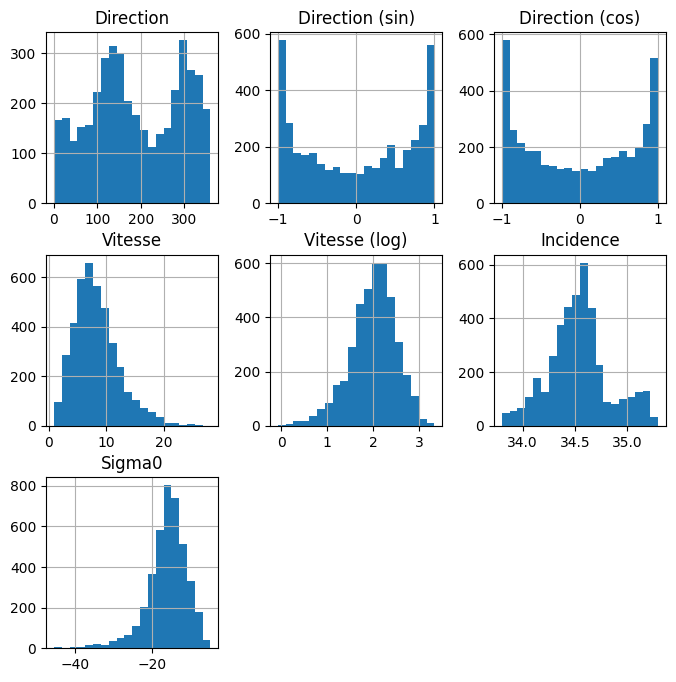

In [9]:
#ax = df.iloc[:,0].plot.hist(bins=12, alpha=0.5)
hist = df.hist(bins=20,figsize=(8,8))

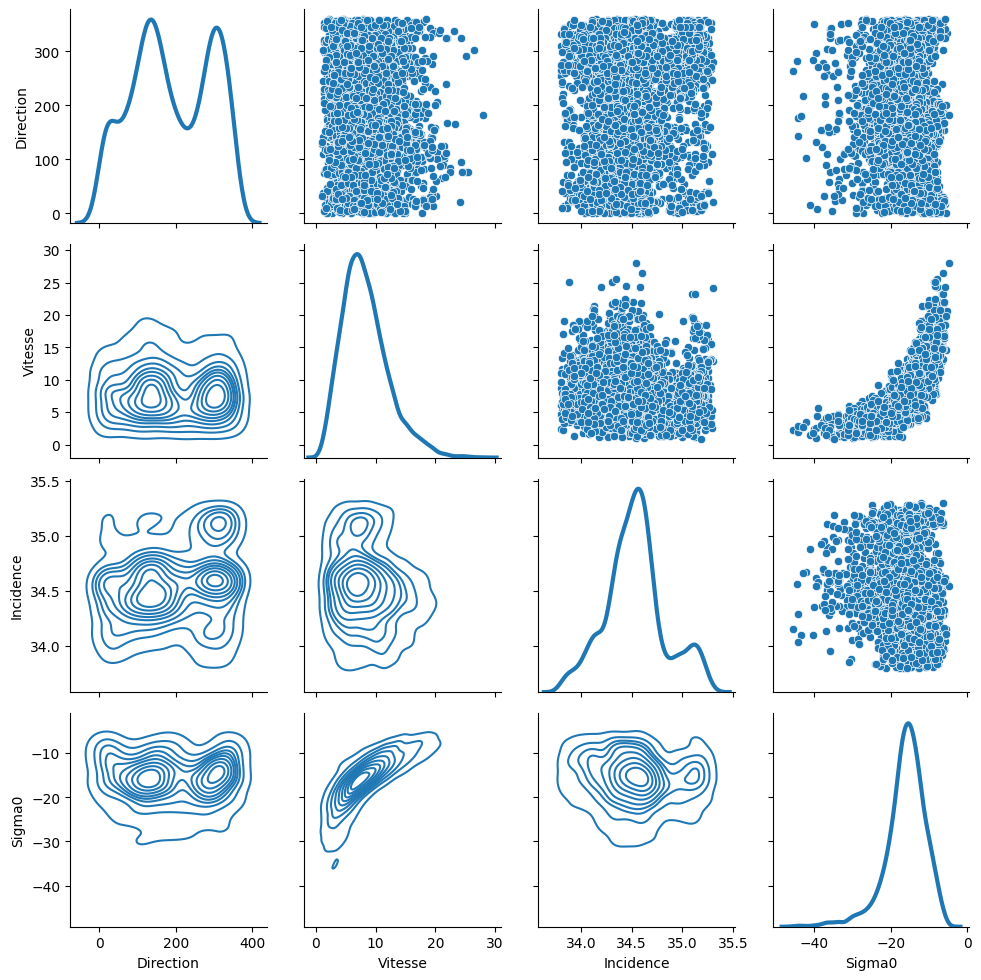

In [10]:
#g = sns.pairplot(df, diag_kind="kde", markers="+",
#                  plot_kws=dict(s=50, edgecolor="b", linewidth=1),
#                  diag_kws=dict(shade=True))
g = sns.PairGrid(df[['Direction','Vitesse','Incidence','Sigma0']], diag_sharey=False)
#g = sns.PairGrid(df(colums=['Direction','Direction (sin)','Direction (cos)','Vitesse','Incidence','Sigma0']), diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot, lw=3)

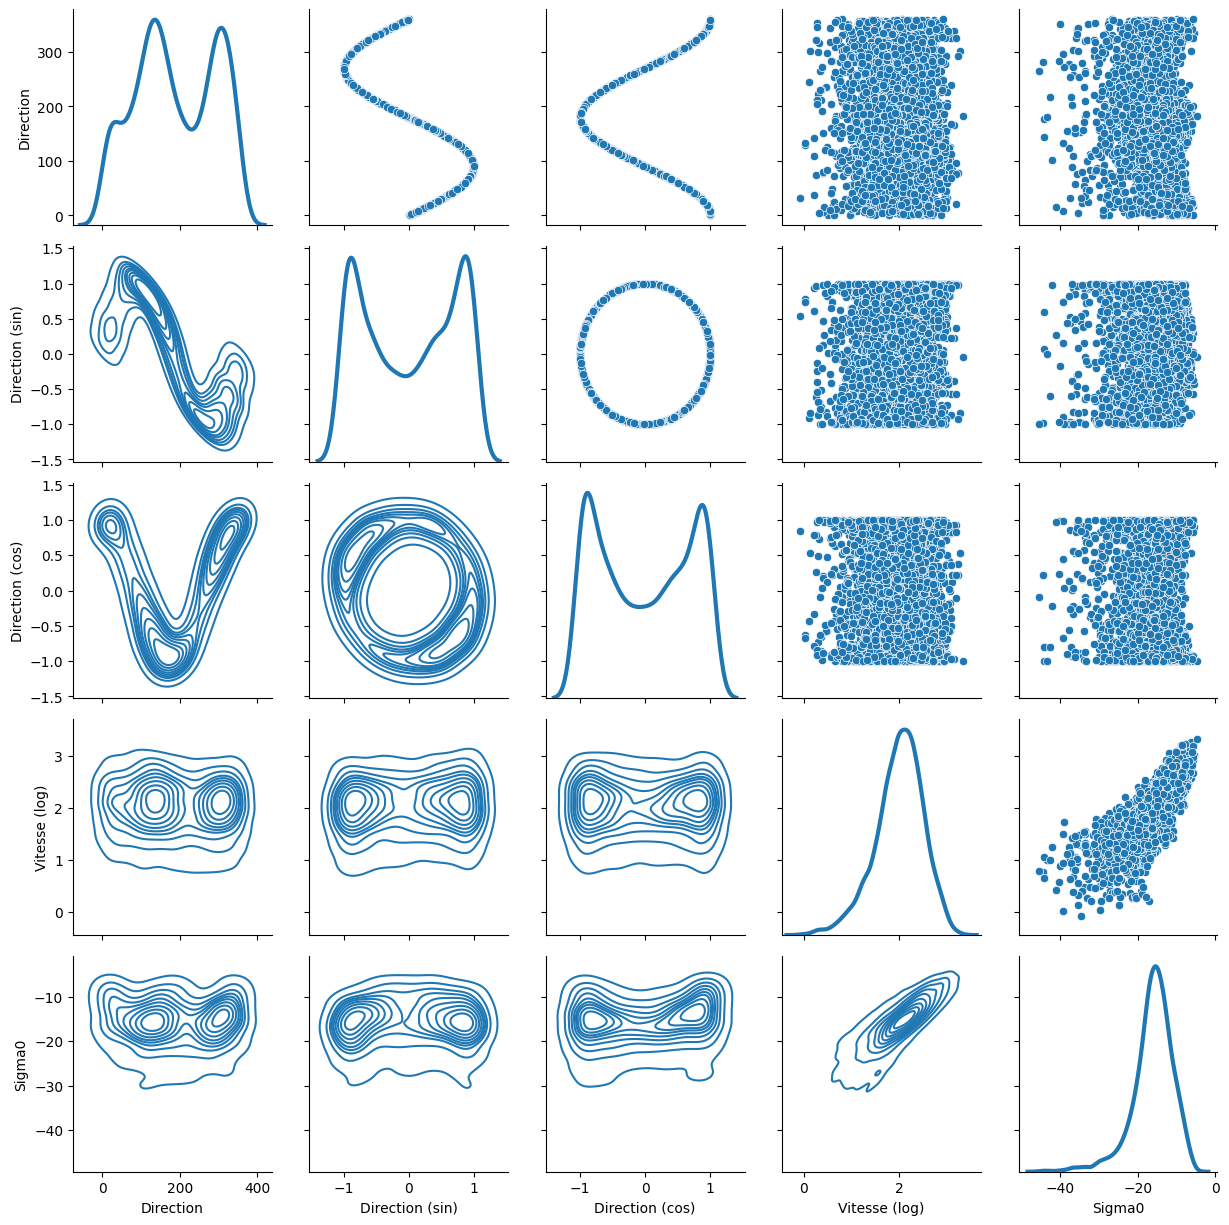

In [11]:
if True:
    g = sns.PairGrid(df[['Direction','Direction (sin)','Direction (cos)','Vitesse (log)','Sigma0']], diag_sharey=False)
    g.map_lower(sns.kdeplot)
    g.map_upper(sns.scatterplot)
    g.map_diag(sns.kdeplot, lw=3)

### Mise en forme et codages des entrées et des sorties du réseau de neurone

In [12]:
#
# moyennes et écarts types,
direction_moyenne = np.mean(direction)
direction_sin_moyenne = np.mean(direction_sin)
direction_cos_moyenne = np.mean(direction_cos)
vitesse_moyenne = np.mean(vitesse)
vitesse_log_moyenne = np.mean(vitesse_log)
incidence_moyenne = np.mean(incidence)
sigma0_moyenne = np.mean(sigma0)

# ecart-types
direction_et = np.std(direction)
direction_sin_et = np.std(direction_sin)
direction_cos_et = np.std(direction_cos)
vitesse_et = np.std(vitesse);
vitesse_log_et = np.std(vitesse_log);
incidence_et = np.std(incidence);
sigma0_et = np.std(sigma0)
#
# Donnees normalisees et matrice d'entree
DirN    = (direction - direction_moyenne ) /  direction_et  * 2/3
Dir_sinN    = direction_sin
#Dir_sinN    = (direction_sin - direction_sin_moyenne ) /  direction_sin_et  * 2/3
Dir_cosN    = direction_cos
#Dir_cosN    = (direction_cos - direction_cos_moyenne ) /  direction_cos_et  * 2/3
VitN    = (vitesse   - vitesse_moyenne   ) /  vitesse_et  * 2/3
Vit_logN    = (vitesse_log   - vitesse_log_moyenne   ) /  vitesse_log_et  * 2/3
IncN    = (incidence - incidence_moyenne ) / incidence_et * 2/3
SigN    = (sigma0    - sigma0_moyenne    ) / sigma0_et    * 2/3
#
choix_vitesse = 'vitesse'
#choix_vitesse = 'vitesse_log'
if choix_vitesse == 'vitesse' : 
    XN      = np.concatenate((Dir_sinN,Dir_cosN, VitN), axis=1)
elif choix_vitesse == 'vitesse_log' : 
    XN      = np.concatenate((Dir_sinN,Dir_cosN, Vit_logN), axis=1)
else:
    raise ValueError('Choix de vitesse inattendu')

**Datasets et Dataloader ?**

In [13]:
from random import shuffle

In [14]:
class DataLoader(object):
    def __init__(self, x, y, batch_size=128, shuffle=True):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.start_idx = 0
        self.data_size = x.shape[0]
        if self.shuffle:
            self.reset()
    
    def reset(self):
        self.x, self.y = shuffle(self.x, self.y)
    
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.start_idx >= self.data_size:
            if self.shuffle:
                self.reset()
            self.start_idx = 0
            raise StopIteration
    
        batch_x = self.x[self.start_idx:self.start_idx+self.batch_size]
        batch_y = self.y[self.start_idx:self.start_idx+self.batch_size]

        batch_x = torch.tensor(batch_x, dtype=torch.float, device=device)
        batch_y = torch.tensor(batch_y, dtype=torch.float, device=device)

        self.start_idx += self.batch_size

        return (batch_x,batch_y)

## 1 ère Partie : Modélisation du diffusiomètre NSCAT

Nous vous demandons de réaliser une régression par PMC pour modéliser la fonction du
diffusiomètre NSCAT. Le rôle du PMC sera donc de donner la valeur de sortie Sigma0 en fonction
de la direction et de la vitesse du vent.

### Réalisation et apprentissage du mlp

In [15]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
# from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset, IterableDataset, Dataset
from torch.utils.data.sampler import SubsetRandomSampler

/Users/dahmani/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
x_train, x_valid, y_train, y_valid = train_test_split(
    XN, SigN, test_size=0.3, random_state=3407,shuffle=True)

x_app = torch.FloatTensor(x_train)
y_app = torch.FloatTensor(y_train)
x_val = torch.FloatTensor(x_valid)
y_val = torch.FloatTensor(y_valid)

In [17]:
y = df['Sigma0']
x = df.drop(columns=['Sigma0'])
X_app, X_test, Y_app, Y_test = train_test_split(XN, SigN, test_size=0.3, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_app, y_app, test_size=0.3, random_state=42)

In [18]:
train_dataloader = DataLoader(X_train, Y_train, batch_size=4000)
valid_dataloader = DataLoader(X_val, Y_val, batch_size=4000)
print(train_dataloader)

In [19]:
x_app = torch.FloatTensor(x_train)
y_app = torch.FloatTensor(y_train)
x_val = torch.FloatTensor(x_valid)
y_val = torch.FloatTensor(y_valid)

In [20]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear_1 = nn.Linear(3,5)
        
        self.out = nn.Linear(5, 1)   # fully connected layer, output 10 classes
        self.relu = torch.nn.Tanh()
    def forward(self, x):
        x = self.relu(self.linear_1(x))
        output = self.out(x)
        return output   # return x for visualization

In [21]:
mlp = MLP()
# optimize all cnn parameters
n_epochs = 10000      # nombre de passage des donnees d'apprentissage
# aining data n times, to save time, we just train 1 epoch
criterion = torch.nn.MSELoss()
BATCH_SIZE = int(x_app.shape[0]/1)
optimizer = torch.optim.SGD(mlp.parameters(), lr = 0.01)

In [22]:
loss_app = []
loss_val = []
for epoch in range(10000):
    for B in range(0,int(x_app.shape[0]/BATCH_SIZE),1):
        optimizer.zero_grad()
        output = mlp(x_app[B*BATCH_SIZE:(B+1)*BATCH_SIZE])
        loss = criterion(output,y_app[B*BATCH_SIZE:(B+1)*BATCH_SIZE])
        loss.backward()
        
        
        optimizer.step() 
    y_pred_val = mlp(x_val)
    loss_val_ = criterion(y_pred_val, y_val)


    loss_app.append(loss.item())
    loss_val.append(loss_val_.item())  

    if epoch % 1000 ==0:
        print(loss)



tensor(0.3196, grad_fn=<MseLossBackward0>)
tensor(0.1486, grad_fn=<MseLossBackward0>)
tensor(0.1461, grad_fn=<MseLossBackward0>)
tensor(0.1444, grad_fn=<MseLossBackward0>)
tensor(0.1431, grad_fn=<MseLossBackward0>)
tensor(0.1419, grad_fn=<MseLossBackward0>)
tensor(0.1406, grad_fn=<MseLossBackward0>)
tensor(0.1392, grad_fn=<MseLossBackward0>)
tensor(0.1374, grad_fn=<MseLossBackward0>)
tensor(0.1355, grad_fn=<MseLossBackward0>)


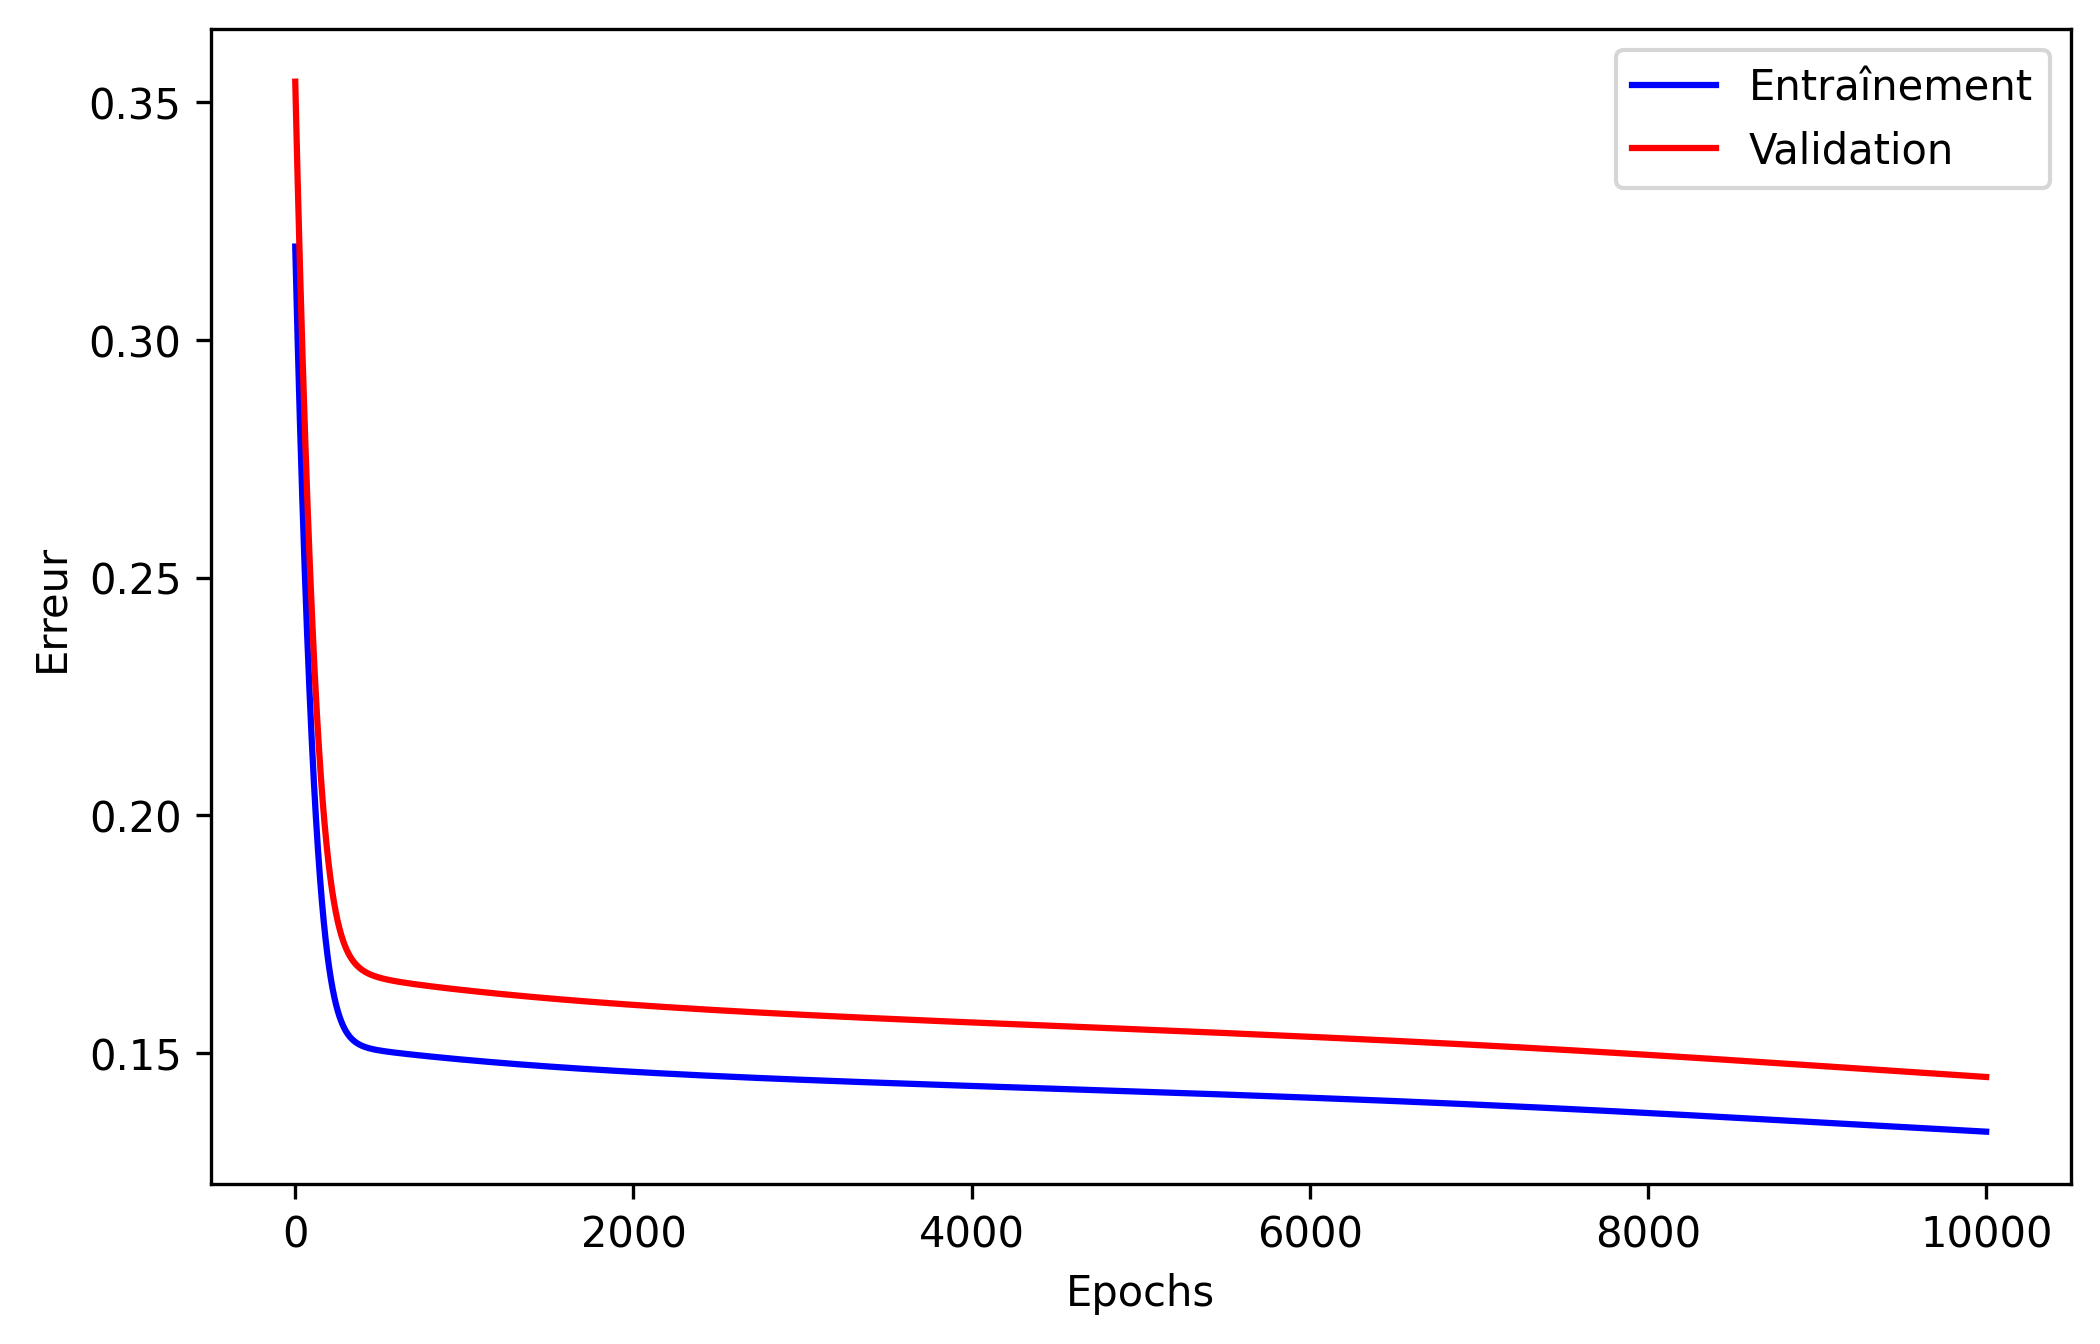

In [23]:
plt.figure(figsize=(8,5),dpi=300)
plt.plot(loss_app,'b')
plt.plot(loss_val,'r')
plt.xlabel('Epochs')
plt.ylabel('Erreur')
plt.legend(['Entraînement','Validation'])

### Visualisation et affichage de la fonction estimée

#### Unbe fonction (au cas où)

In [24]:
def tracerLesDonneesEnCouleur(x,y,c,classes_edges=None,nombreDeClasses = 100,cb_label=''):
    if classes_edges==None:
        classes_edges = np.linspace(c.min(),c.max(),nombreDeClasses)
    else:
        raise NotImplementedError("A faire, attention.")
        classes_edges = np.array(classes_edges).astype(float)
    classes_edges[0] , classes_edges[-1] = -np.infty, np.infty
    classes_indices = np.digitize(c,classes_edges)

    cmap = matplotlib.cm.hot
    cmap = matplotlib.cm.jet
    norm = matplotlib.cm.colors.Normalize(vmin=c.min(), vmax=c.max())
    colors = cmap(np.linspace(0,1,nombreDeClasses))
    for k in range(nombreDeClasses): # boucle sur les mois
        selec_classes = np.where(classes_indices==k)
        if len(selec_classes[0]) != 0:
            h = plt.plot(x[selec_classes], y[selec_classes[0]],'.', color=colors[k])

            
    ax = plt.gca()
    pos1 = ax.get_position() # get the original position 
    if False:
        pos2 = [pos1.x0, pos1.y0+pos1.height*.125,  pos1.width , pos1.height*.85] 
        pos3 = [pos1.x0, pos1.y0,  pos1.width , pos1.height*.025] 
        orientation='horizontal'
    else:
        pos2 = [pos1.x0, pos1.y0,  pos1.width*.825 , pos1.height] 
        pos3 = [pos1.x0+pos1.width*.85, pos1.y0,  pos1.width*.025 , pos1.height] 
        orientation='vertical'
            
    ax.set_position(pos2) #
    ax_cb = fig.add_axes(pos3)    
    cb = matplotlib.colorbar.ColorbarBase(ax_cb,cmap=cmap,
                                          norm=norm, 
                                          orientation=orientation)
    #cb.set_label(cb_label)
    cb.ax.get_yaxis().labelpad = 15
    cb.ax.set_ylabel(cb_label, rotation=270)

    plt.sca(ax)
    
    return colors, classes_edges 

In [25]:
XN1=torch.FloatTensor(XN)
YN1=mlp(XN1)
YN=YN1.detach().numpy()

Text(0.5, 0, 'Direction normalisée []')

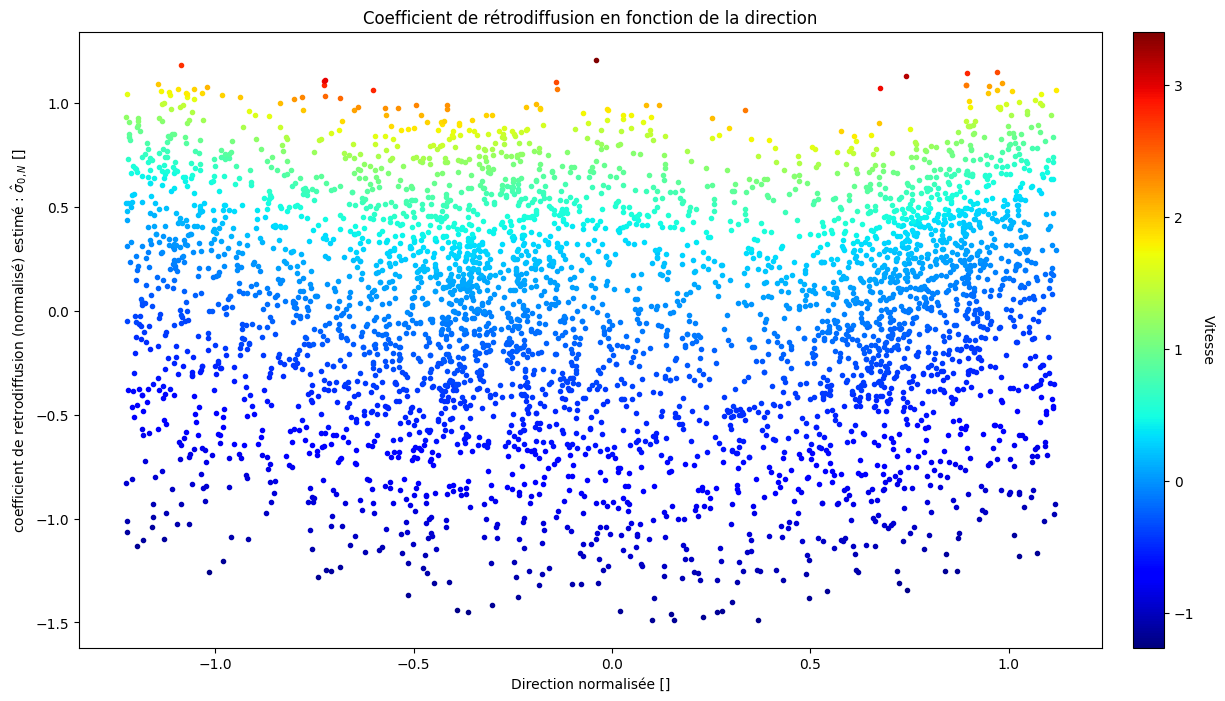

In [26]:
fig, ax = plt.subplots(1,1,figsize=(16,8))
tracerLesDonneesEnCouleur(DirN,YN,VitN,nombreDeClasses = 100,cb_label="Vitesse")
plt.title("Coefficient de rétrodiffusion en fonction de la direction")
plt.ylabel("coefficient de retrodiffusion (normalisé) estimé : $\hat{\sigma}_{0,N}$ []")
plt.xlabel("Direction normalisée []")

Text(0.5, 0, 'Direction normalisée')

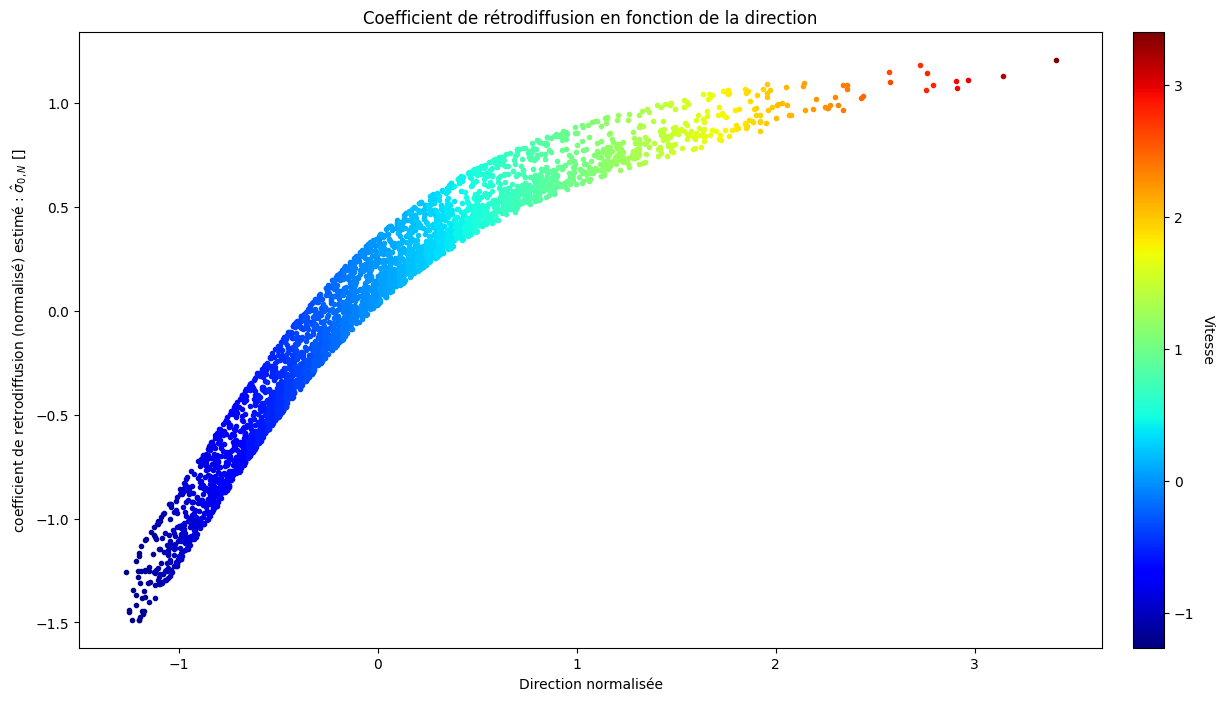

In [27]:
fig, ax = plt.subplots(1,1,figsize=(16,8))
tracerLesDonneesEnCouleur(VitN,YN,VitN,nombreDeClasses = 100,cb_label="Vitesse")
plt.title("Coefficient de rétrodiffusion en fonction de la direction")
plt.ylabel("coefficient de retrodiffusion (normalisé) estimé : $\hat{\sigma}_{0,N}$ []")
plt.xlabel("Direction normalisée")

**Calcul des erreurs**

In [28]:
def bias(y,yp):
   return (1/len(y)*np.sum(np.abs(y-yp),axis=0))
def rmsr(y,yr):
   return np.sqrt((1/len(y))*(np.sum(np.square(np.subtract(y,yr))) / np.sum(np.square(np.subtract(y, np.mean(y))))))

In [29]:
print("Train RMS",np.sqrt(mean_squared_error(output.detach().numpy() , y_train)))
print("Train Bias",bias(y_train,output.detach().numpy()))
print("Train RMSR",rmsr(y_train,output.detach().numpy()))

Train RMS 0.3653643474581148
Train Bias [0.24710543]
Train RMSR 0.010354969572233719


#### Par intervalle 

In [30]:
step=2
X = np.hstack((direction,direction_sin,direction_cos,vitesse,vitesse_log,incidence,sigma0))
variables = ['Direction','Direction (sin)','Direction (cos)','Vitesse','Vitesse (log)','Incidence','Sigma0']
df_inv= pd.DataFrame(X,columns=variables)
df_inv['VitN']=VitN 
df_inv['sigN']=SigN
max_=max(df['Vitesse'])
min_=min(df['Vitesse'])
iterations=((max_-min_)/step)
start=min_
End=min_+step
train_list=[]
l_interval=[]
train_listy=[]
ly=[]

In [31]:
for i in range(int(iterations)+1) :
  for j in df_inv.values:
    if(j[3]>=start and j[3]<End):
      vector=[j[1],j[2],j[7]]
      l_interval.append(vector)
      ly.append(np.std(j[8]))
  train_list.append(l_interval)
  train_listy.append(ly)
  start=End
  End=End+2
  l_interval=[]
  ly=[]
start=min_
End=min_+2

for i in range(int(iterations)) :
      if (train_list[i]):
        RSE_numpy = np.sum(np.square(np.subtract(train_listy[i],output.detach().numpy()))) / np.sum(np.square(np.subtract(y_valid, np.mean(y_valid))))
        print("RSE dans l'intervalle : [",start,End,"] ==>", RSE_numpy,len(train_list[i]))
      else :
        print("RSE dans l'intervalle : [",start,End,"] ==>vide",len(train_list[i]))
      start=End
      End=End+step

RSE dans l'intervalle : [ 0.93 2.93 ] ==> 289.69437610402764 199
RSE dans l'intervalle : [ 2.93 4.93 ] ==> 829.777861202491 570
RSE dans l'intervalle : [ 4.93 6.93 ] ==> 1295.6180639828374 890
RSE dans l'intervalle : [ 6.93 8.93 ] ==> 1304.3525677849684 896
RSE dans l'intervalle : [ 8.93 10.93 ] ==> 965.1626701355293 663
RSE dans l'intervalle : [ 10.93 12.93 ] ==> 595.4020091786294 409
RSE dans l'intervalle : [ 12.93 14.93 ] ==> 296.9731292724705 204
RSE dans l'intervalle : [ 14.93 16.93 ] ==> 193.61483428058125 133
RSE dans l'intervalle : [ 16.93 18.93 ] ==> 103.35829499188925 71
RSE dans l'intervalle : [ 18.93 20.93 ] ==> 55.31852408016607 38
RSE dans l'intervalle : [ 20.93 22.93 ] ==> 20.38050887164013 14
RSE dans l'intervalle : [ 22.93 24.93 ] ==> 8.734503802131485 6
RSE dans l'intervalle : [ 24.93 26.93 ] ==> 5.823002534754323 4


#### Affichage du diagramme de dispersion ?

In [32]:
Y = YN * 3/2 * sigma0_et + sigma0_moyenne

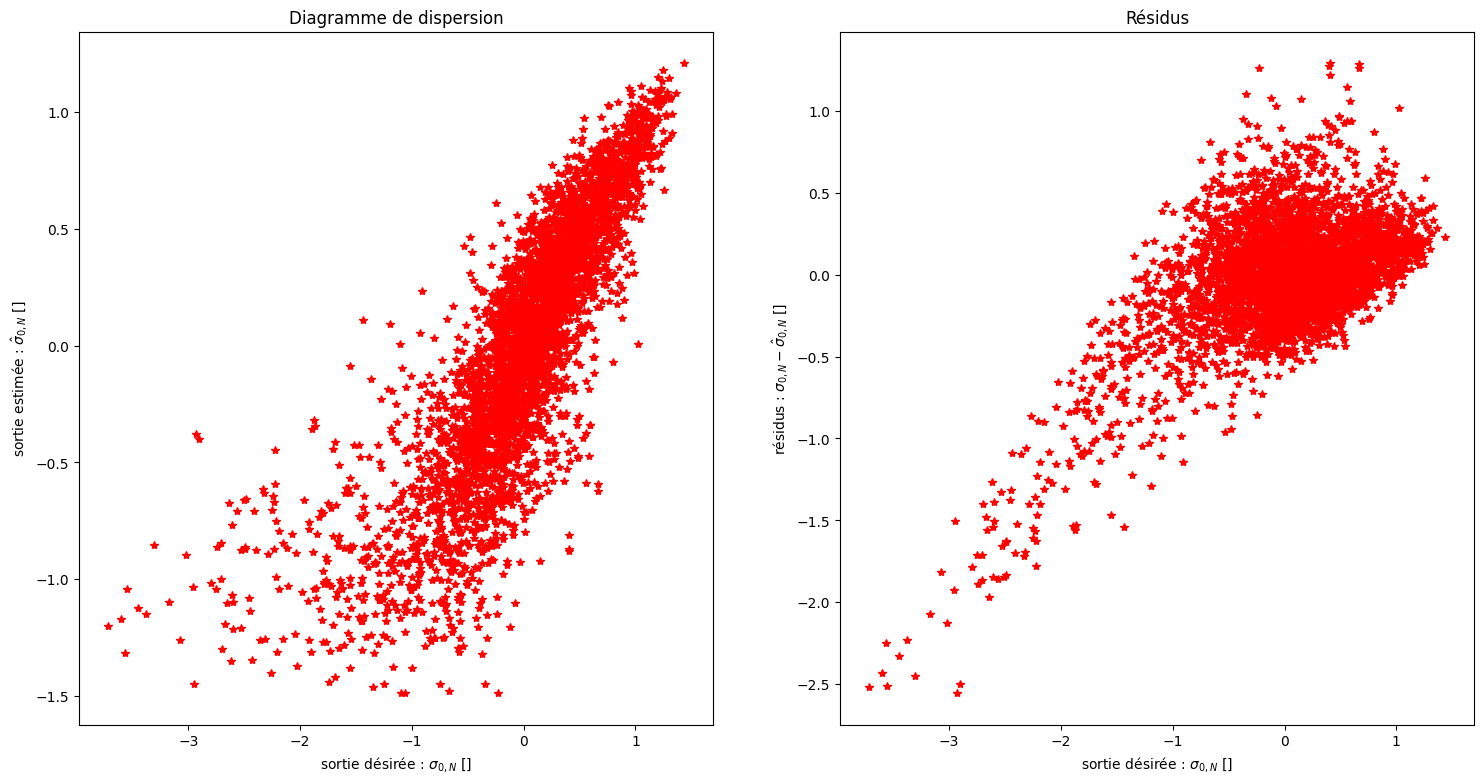

In [33]:
plt.figure(figsize=(18,9))
plt.subplot(1,2,1)
plt.plot(SigN,YN,'*r')
plt.title("Diagramme de dispersion")
plt.ylabel("sortie estimée : $\hat{\sigma}_{0,N}$ []")
plt.xlabel("sortie désirée : $\sigma_{0,N}$ []")
plt.subplot(1,2,2)
plt.plot(SigN,SigN-YN,'*r')
plt.title("Résidus")
plt.xlabel("sortie désirée : $\sigma_{0,N}$ []")
plt.ylabel("résidus : $\sigma_{0,N}-\hat{\sigma}_{0,N}$ []") ;

/var/folders/jc/s5z2r_g96mqf6zxqdrrz7kjh0000gp/T/ipykernel_16528/1409874570.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


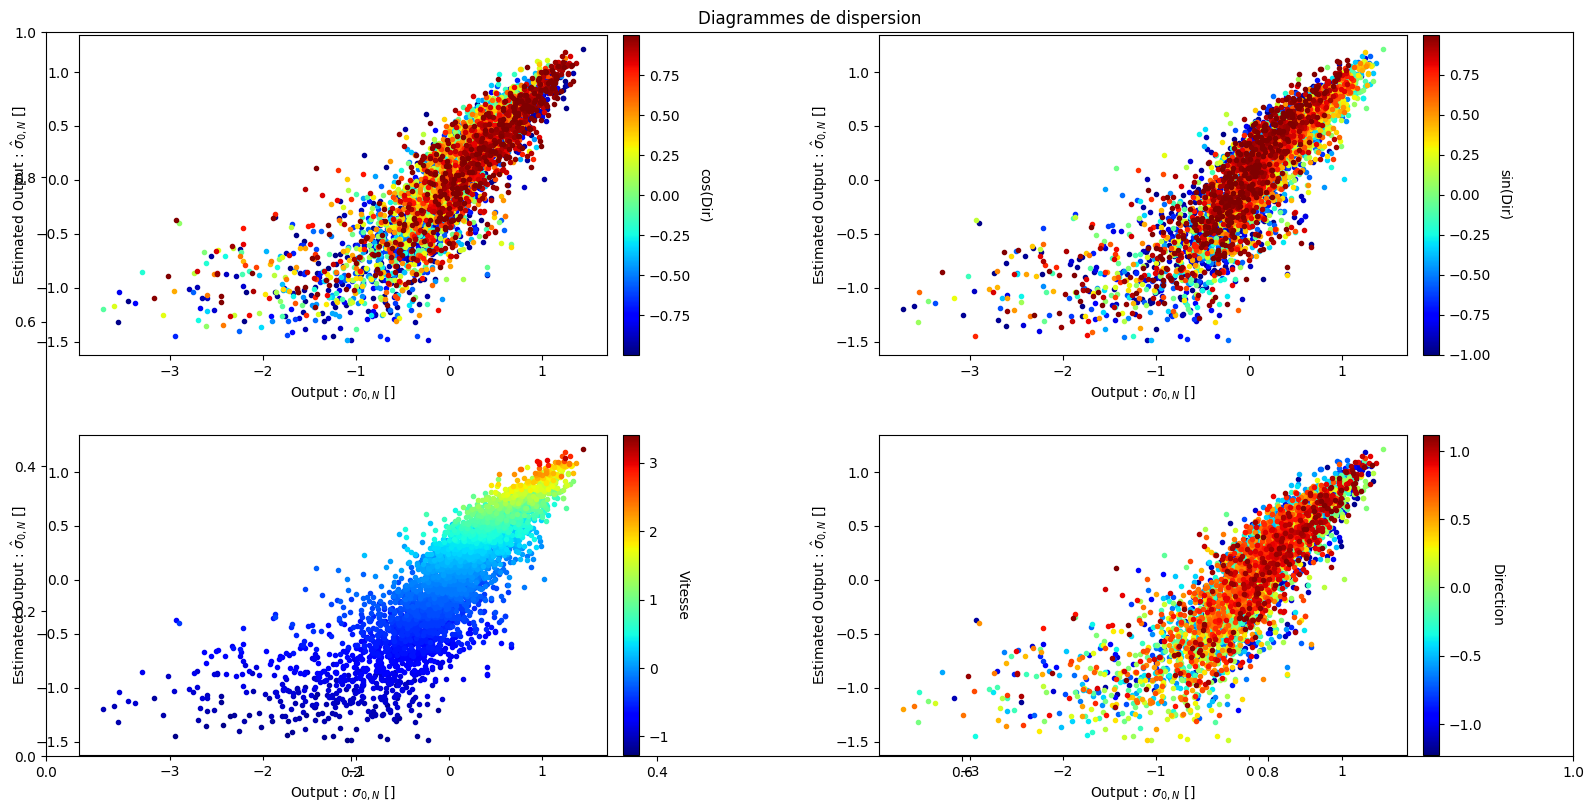

In [34]:
fig = plt.figure(figsize=(16,8))
plt.title("Diagrammes de dispersion")
ax = [ [fig.add_axes((.05,.05,.4,.4)),fig.add_axes((.55,.05,.4,.4))],
       [fig.add_axes((.05,.55,.4,.4)),fig.add_axes((.55,.55,.4,.4))] ]
plt.sca(ax[0][0])
tracerLesDonneesEnCouleur(SigN,YN,VitN,nombreDeClasses = 100,cb_label="Vitesse")
plt.ylabel("Estimated Output : $\hat{\sigma}_{0,N}$ []")
plt.xlabel("Output : $\sigma_{0,N}$ []")
plt.sca(ax[0][1])
tracerLesDonneesEnCouleur(SigN,YN,DirN,nombreDeClasses = 100,cb_label="Direction")
plt.ylabel("Estimated Output : $\hat{\sigma}_{0,N}$ []")
plt.xlabel("Output : $\sigma_{0,N}$ []")
plt.tight_layout()
plt.sca(ax[1][0])
tracerLesDonneesEnCouleur(SigN,YN,Dir_cosN,nombreDeClasses = 100,cb_label="cos(Dir)")
plt.ylabel("Estimated Output : $\hat{\sigma}_{0,N}$ []")
plt.xlabel("Output : $\sigma_{0,N}$ []")
plt.sca(ax[1][1])
tracerLesDonneesEnCouleur(SigN,YN,Dir_sinN,nombreDeClasses = 100,cb_label="sin(Dir)")
plt.ylabel("Estimated Output : $\hat{\sigma}_{0,N}$ []")
plt.xlabel("Output : $\sigma_{0,N}$ []") ; 

#### Affichage des Résidus ? 

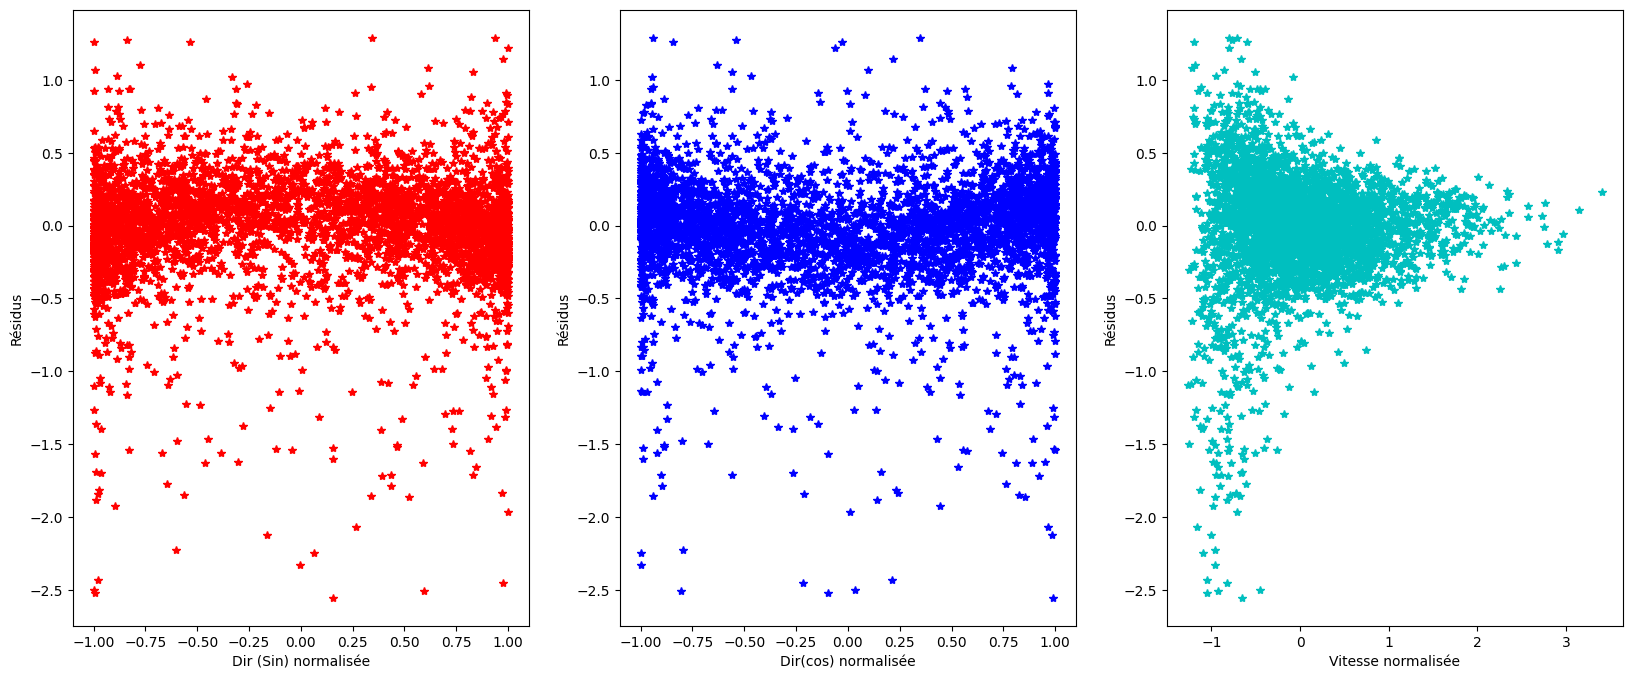

In [36]:
plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
plt.plot(Dir_sinN,SigN-YN,'*r')
plt.ylabel("Résidus")
plt.xlabel("Dir (Sin) normalisée")
plt.subplot(1,3,2)
plt.plot(Dir_cosN,SigN-YN,'*b')
plt.ylabel("Résidus")
plt.xlabel("Dir(cos) normalisée")
plt.subplot(1,3,3)
plt.plot(VitN,SigN-YN,'*c')
plt.ylabel("Résidus")
plt.xlabel("Vitesse normalisée");

## 2ème Partie : Encadrement par approximation de la variance

Afin d’attacher des intervalles de confiance aux résultats trouvés, on propose d’estimer la
variance du bruit en fonction des données.  
La méthode proposée a déjà été mise en œuvre dans un
TP précédent.